<a href="https://colab.research.google.com/github/Naym0/super-eureka/blob/master/Task2/ML_Task_Group_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

In [0]:
data = pd.read_csv('train_data.csv')

## Dealing with missing values

In [0]:
replace_with_mode = ['Electrical', 'MasVnrType']

for feature in replace_with_mode:
  mode_value = data[feature].mode()[0]
  data[feature].fillna(mode_value, inplace=True)

# replace with mean
mean_value = data['MasVnrArea'].mean()
data['MasVnrArea'].fillna(mean_value, inplace=True)

# replace with NA string
replace_with_NA = [
                   'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2',
                   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                   'Fence',
                   'Alley',
                   'MiscFeature',
                   'FireplaceQu',
                   'PoolQC'
                   ]
for feature in replace_with_NA:
  data[feature].fillna('NA', inplace=True)

# Replace with 0
for feature in ['GarageYrBlt','LotFrontage']:
  data[feature].fillna(0, inplace=True)

## Encoding categorical data

In [0]:
#yes or no
nominal = ['Street','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation','Heating','CentralAir','Electrical','Functional','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
#some sort of rank
ordinal = ['MSZoning','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PoolQC','Fence']
#what is being predicted
target = 'SalePrice'

# integer encoding
for ordinal_feature in ordinal:
  data[ordinal_feature] = data[ordinal_feature].astype('category').cat.codes

# One Hot Encoding
df_dummies = pd.get_dummies(data[nominal])
data = pd.concat([df_dummies, data], axis=1)
data.drop(nominal, axis=1, inplace=True)

## PCA

In [0]:
X = data.loc[:, data.columns != target].values
Y = data.loc[:,target].values

# Standardize data to fit Gaussian/Normal Distribution
X = StandardScaler().fit_transform(X)

## Using 2 Principal Components

In [0]:
pca = PCA(n_components=2)
p_components = pca.fit_transform(X)
pca_data = pd.DataFrame(p_components, columns=['PC1', 'PC2'])
final_data = pd.concat([pca_data, data[target]], axis=1)

## Percentage of information carried by the PCs

In [16]:
info_percentages = list(map(lambda x: x*100, pca.explained_variance_ratio_))
print("PC1: {}%  PC1: {}%".format(*info_percentages))

PC1: 6.4913180444680005%  PC1: 3.1167604926046897%


In [33]:
pca_90_var = PCA(.90)
p90_components = pca_90_var.fit_transform(X)
print("To caputure 90% variance you would require",p90_components.shape[1],"PCs")

To caputure 90% variance you would require 125 PCs


## 3D plane of best fit

In [35]:
X_train = final_data.drop(target, 1)
Y_train = final_data[target]
regressor =  LassoCV()
regressor.fit(X_train, Y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [40]:
W_1, W_2 = regressor.coef_
b = regressor.intercept_

final_data_array = final_data.to_numpy()
min_val = np.min(final_data_array, axis=0)
max_val = np.max(final_data_array, axis=0)
X, Y = np.meshgrid(np.linspace(min_val[0], max_val[0], 20), np.linspace(min_val[1], max_val[1], 20))
Z = W_1*X + W_2*Y + b

print("The general linear regression equation: \n Y = X_1({}) * X_2({}) + {}".format(W_1,W_2,b))

The general linear regression equation: 
 Y = X_1(16816.06998446436) * X_2(3373.4641259288314) + 180921.19589041095


Text(0.5, 0.92, 'Plan of Best Fit')

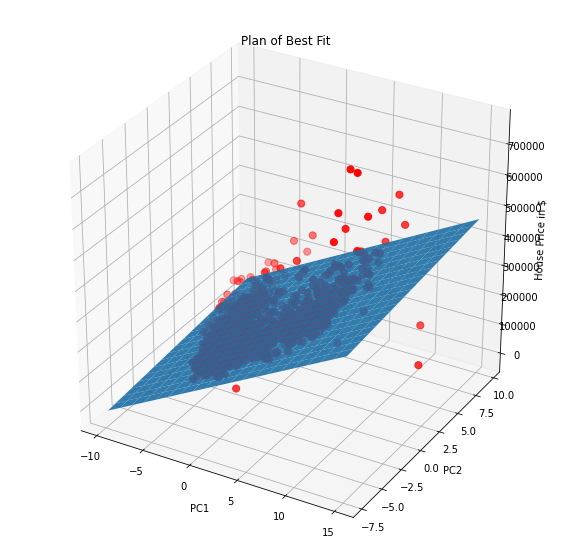

In [43]:
fig1 = plt.figure(figsize=(10,10))
ax = fig1.gca(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.9)
ax.scatter(final_data_array[:,0], final_data_array[:,1], final_data_array[:,2], c='r', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_zlabel('House Price in $')
ax.set_title('Plane of Best Fit')